In [1]:
from Classifier.load_data import read_arduino, process_data, read_arduinbro, load_training_data
from Classifier.classifier import (streaming_classifier,
                                   three_pronged_smoothing_classifier,
                                   two_pronged_smoothing_classifier,
                                   one_pronged_smoothing_classifier,
                                   zeroes_classifier,
                                   catch22_knn_classifier)

from copy import deepcopy
# from Levenshtein import distance as levenshtein_distance
from scipy import signal
import serial
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.io import wavfile
from scipy.fft import fft, fftfreq, fftshift
import wave, struct



import numpy.lib.stride_tricks



In [2]:
# Whole wave
time_buffers = {"data3":(-0.2, 1.15),
                "data2":(-0.2, 1.15),
                "data0":(-0.2, 1.15),
                "data1":(-0.2, 1.15),
                "data5":(-0.4, 1.35),
                "data4":(-0.4, 1.35)}

In [3]:
"""
from numba import njit

@njit
"""
def get_event_regions(wav_array, samprate, labels_dat, time_buffer):
    
    before_buffer = time_buffer[0]
    after_buffer = time_buffer[1]
    
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

    left_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "L"]:
        left_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | left_events_bool

    right_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "R"]:
        right_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | right_events_bool

    event_bool = left_events_bool | right_events_bool
    return event_bool

#@njit


def get_test_stats(wav_array, window_size, step, test_stat_fns):
    test_stats = np.zeros((len(test_stat_fns), len(wav_array)))
        
    all_windows = numpy.lib.stride_tricks.sliding_window_view(wav_array, window_shape = window_size)

    all_windows = all_windows[::step, :]
    
    for i, fn in enumerate(test_stat_fns):
        if i == "Smoothed Zero Crossings jasdkjabdskjabsdkjsakjbd":
            testicles = np.apply_along_axis(fn, -1, all_windows, window_size)
        else:   
            testicles = np.apply_along_axis(fn, -1, all_windows)
        for j, teste in enumerate(testicles):
            if j == len(testicles)-1:
                test_stats[i, (j*step)::]  = teste
            else:
                test_stats[i, (j*step):((j+1)*step)]  = teste
    return test_stats




        
    
def get_contrast(wav_array, samprate, labels_dat, window_size, step, test_stat_fns, contrast_fn, time_buffer):
    test_stats = get_test_stats(wav_array, window_size, step, test_stat_fns)
    
    events_bool = get_event_regions(wav_array, samprate, labels_dat, time_buffer)

    event_test_stats = test_stats[:, events_bool]           
    non_event_test_stats = test_stats[:, ~events_bool]
    
    
    contrast_stat = contrast_fn(event_test_stats, non_event_test_stats)
    
    return contrast_stat
    
    
    
def contrast_all_files(window_size, 
                       test_stat_fns,
                       samprate,     
                       waves,        
                       labels,       
                       contrast_fn,
                       step=0.1):   
    
    step = int(step*samprate)
    start = time.time()
    
    for i, key in enumerate(waves.keys()):
        wav_array = waves[key]
        labels_dat = labels[key]
        
        cont = get_contrast(wav_array, samprate, labels_dat,
                         window_size, step, test_stat_fns,
                         contrast_fn, time_buffers[key])
        
        with open("event_detection_optimisation.csv", "a") as file:
            file.write(",".join([str(window_size), key]) + "," + ','.join(np.round(cont, 4).astype(str)) + "\n")

         

In [4]:
# Define Test Stat Functions

def ts_smooth_zero_crossings(x, window_length = 100):
    filtered_x = signal.savgol_filter(x, window_length, 1)
    return np.sum(filtered_x[0:-1]*filtered_x[1::] <= 0)
def ts_range(x): 
    return np.max(x) - np.min(x)
def ts_IQR(x): 
    return np.quantile(x, 0.75) - np.quantile(x, 0.25)
def ts_abs_max(x): 
    return np.max(np.abs(x))
def ts_zero_crossings(x):
    return np.sum(x[0:-1]*x[1::] <= 0)
def max_frequency(frame, samprate=10000):
    fs = samprate
    dt = 1/fs
    t = np.arange(0, (len(frame)*dt), dt)

    # Num samples
    N = len(frame)

    yf = fft(frame)
    xf = fftfreq(N, 1/fs)
    np.size(xf)
    np.size(t)

    f, t, Sxx = signal.spectrogram(frame, fs)
    maximum = np.max(Sxx)
    threshold = maximum/5;
    maximum_Freqs = np.amax(Sxx, 0) # max frequency for each time

    return np.amax(maximum_Freqs)



In [5]:
waves, labels, samprate = load_training_data(path = "Datasets/",
                                             scale_factor= 1,
                                             blacklist = ["data0"],
                                             whitelist = ["data"])

samprate = 10_000




dict_keys(['data3', 'data2', 'data1', 'data5', 'data4']) dict_keys(['data1', 'data3', 'data2', 'data5', 'data4'])


/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Classifier/load_data.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


In [6]:

"""
labels1 = np.array([])
waves1 = []
i = 0
for key in waves.keys():
    waves1.append(list(waves[key]))
print(type(waves1))
print(type(waves1[1]))
print(type(waves1[1][1]))
waves1 = np.ndarray(waves1, np.float64)
print(waves1[1])
print(len(waves1))
print(len(waves1[5]))
"""

tfn_candidates = {"Range": ts_range,
                  "IQR": ts_IQR,
                  "SD": np.std,
                  "Absolute Max": ts_abs_max,
                  "Zero Crossings": ts_zero_crossings,
                  "Fourier": max_frequency}


def contrast(x, y): 
    pooled_sd = np.sqrt(np.var(x)/len(x) + np.var(y)/len(y))
    return (np.mean(x, axis=1) - np.mean(y, axis=1))/pooled_sd

open("event_detection_optimisation.csv", 'w').close()    # Clears the file so that the code can be run again.


contrasts = []
for x in np.linspace(100, 20000, 200):
    x = int(x)
    print(x)
    contrast_all_files(window_size = x, 
                           test_stat_fns = tfn_candidates.values(),
                           samprate = samprate,
                           waves = waves,
                           labels = labels,
                           step = 0.1,
                           contrast_fn = contrast
                      )


100


/Users/billydodds/.pyenv/versions/3.9.0/envs/data3888/lib/python3.9/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '


200


/Users/billydodds/.pyenv/versions/3.9.0/envs/data3888/lib/python3.9/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600


In [7]:
contrasts = pd.read_csv("event_detection_optimisation.csv", header=None)
contrasts.columns = ["window_size", "file"] + list(tfn_candidates.keys())
contrasts

,window_size,file,Range,IQR,SD,Absolute Max,Zero Crossings,Fourier
0,100,data3,0.0202,0.0088,0.0096,4.0407,-0.7712,0.0012
1,100,data2,-0.0740,-0.0794,-0.0327,3.8340,-0.6386,-0.0030
2,100,data1,-0.0024,-0.0121,-0.0031,3.7571,-0.8039,0.0002
3,100,data5,0.0420,-0.0070,0.0081,4.1109,-0.8727,0.0005
4,100,data4,0.0487,0.0606,0.0224,3.9580,-0.5653,0.0021
...,...,...,...,...,...,...,...,...
995,20000,data3,-0.0423,-0.0032,-0.0114,0.0149,0.0695,-0.0093
996,20000,data2,0.0392,0.0028,0.0047,0.0496,-0.5379,0.0111
997,20000,data1,0.0620,0.0095,0.0116,0.0494,-0.8625,0.0172
998,20000,data5,0.0945,0.0668,0.0276,0.0456,-1.5801,0.0402


In [8]:
contrasts_total = contrasts.groupby("window_size").mean()

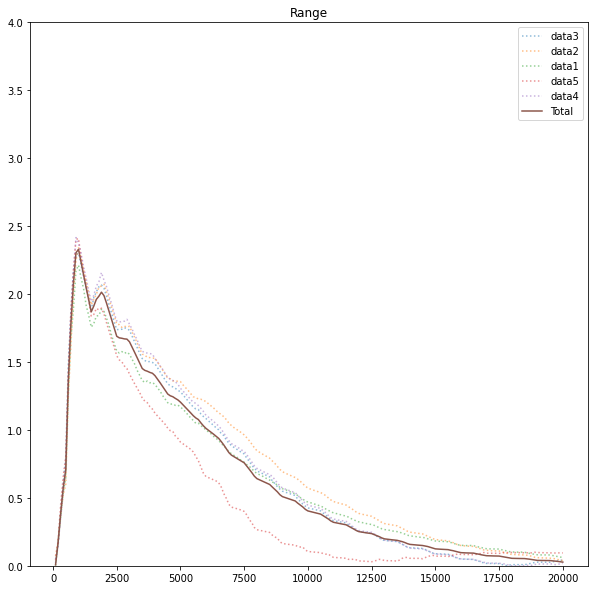

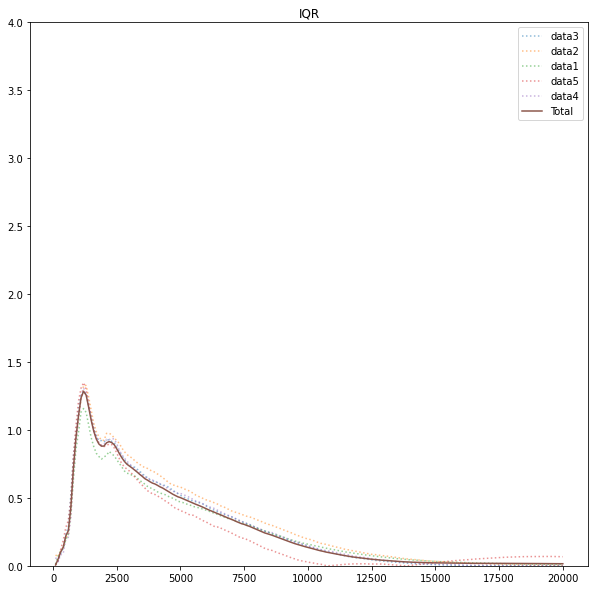

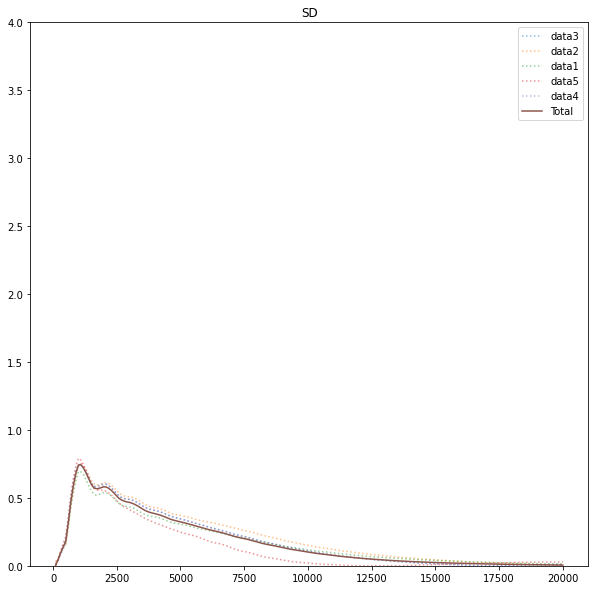

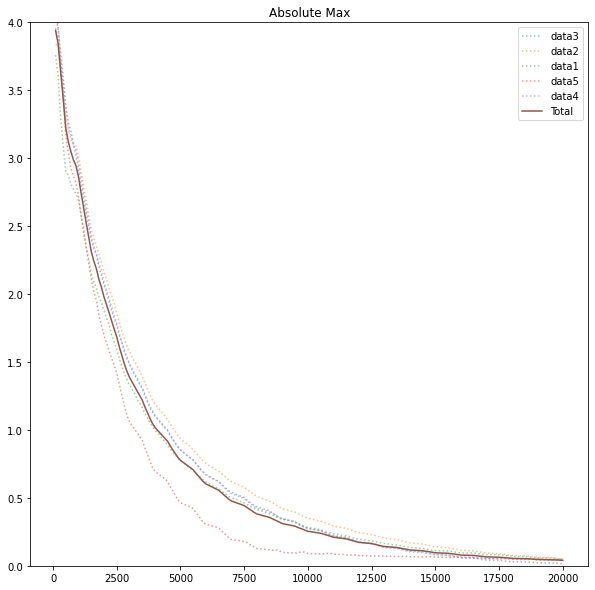

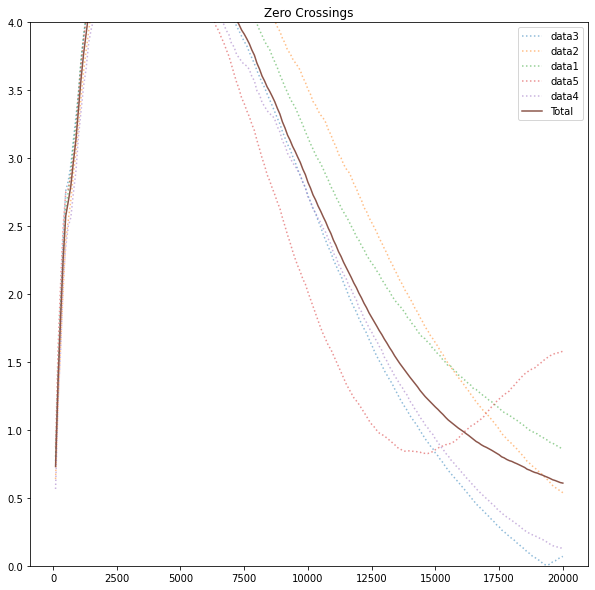

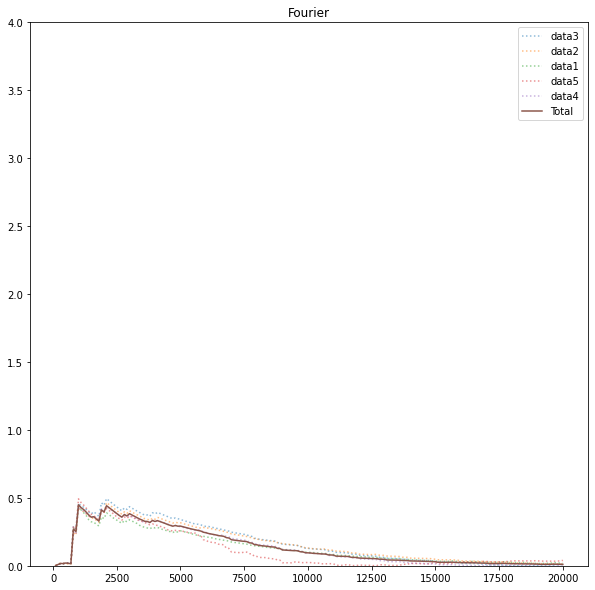

In [9]:
# plt.plot(contrasts[:, 0])
for stat in tfn_candidates.keys():
    plt.figure(figsize=(10, 10))
    plt.ylim(0, 4)
    for file in waves.keys():
        plt.plot(contrasts[contrasts.file == file].window_size,
                 np.abs(contrasts[contrasts.file == file][stat]),
                 label = file, alpha = 0.5, linestyle=":") 
    
    plt.plot(contrasts_total.index,
             np.abs(contrasts_total[stat]),
             label = "Total", alpha = 1)
    plt.legend()
    plt.title(stat)

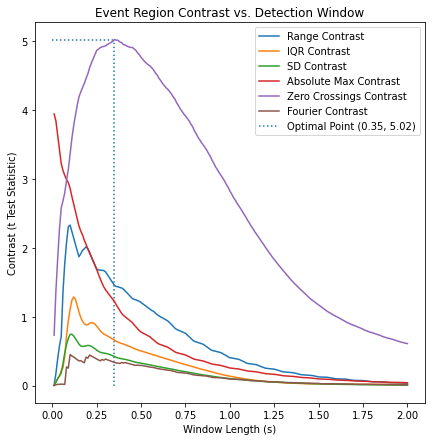

In [23]:
plt.figure(figsize=(7, 7))

for stat in tfn_candidates.keys():
    plt.plot(contrasts_total.index/samprate,
             np.abs(contrasts_total[stat]),
             label = f"{stat} Contrast", alpha = 1)

plt.title("Event Region Contrast vs. Detection Window")
plt.xlabel("Window Length (s)")    
plt.ylabel("Contrast (t Test Statistic)")  





opt_zerocrossings = contrasts_total.index[np.argmax(np.abs(contrasts_total["Zero Crossings"]))]/samprate
opt_zerocrossings_val = np.max(np.abs(contrasts_total["Zero Crossings"]))


plt.vlines(opt_zerocrossings, 0, opt_zerocrossings_val,linestyle=":", label=f"Optimal Point ({round(opt_zerocrossings, 2)}, {round(opt_zerocrossings_val, 2)})")
plt.hlines(opt_zerocrossings_val, 0, opt_zerocrossings,linestyle=":")


plt.legend()




plt.savefig("contrast.png")





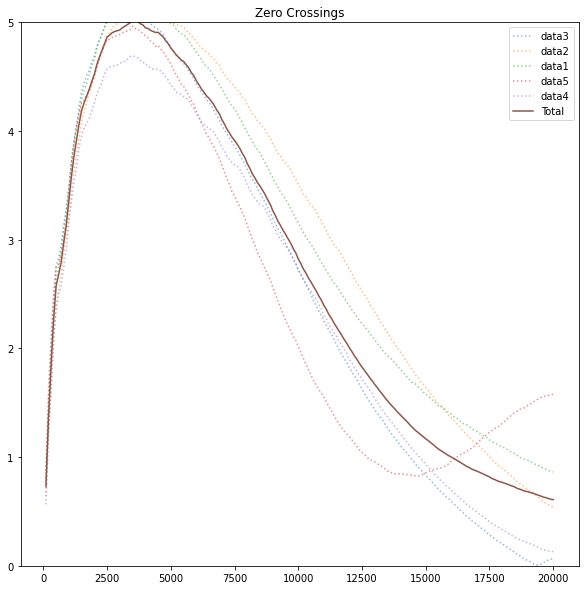

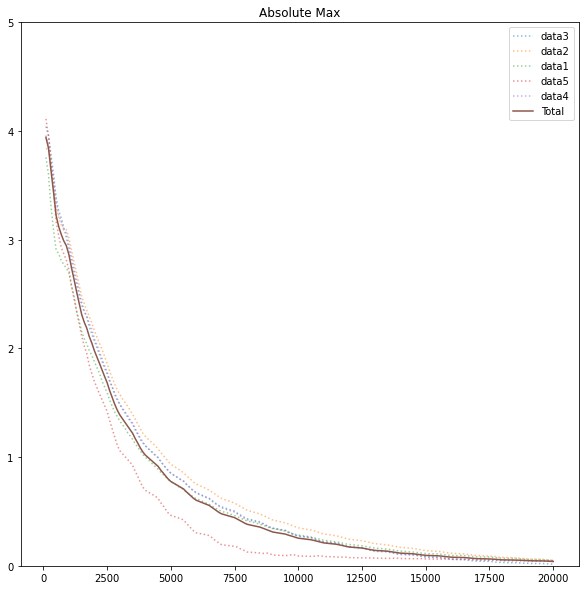

In [11]:

for stat in ["Zero Crossings", "Absolute Max"]:
    plt.figure(figsize=(10, 10))

    plt.ylim(0, 5)
    for file in waves.keys():
        plt.plot(contrasts[contrasts.file == file].window_size,
                 np.abs(contrasts[contrasts.file == file][stat]),
                 label = file, alpha = 0.5, linestyle=":") 
    
    plt.plot(contrasts_total.index,
             np.abs(contrasts_total[stat]),
             label = "Total", alpha = 1)
    plt.legend()
    plt.title(stat)
    

In [12]:


opt_zerocrossings = contrasts_total.index[np.argmax(np.abs(contrasts_total["Zero Crossings"]))]

opt_zerocrossings



3500

In [13]:
window_size = opt_zerocrossings/samprate
print(window_size)

0.35
